# Real Estate Price Prediction

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    # 121 - nrows, ncols, index (индекс 1)
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    # 121 - nrows, ncols, index (индекс 2)
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
train_df.shape, test_df.shape

((10000, 20), (5000, 19))

### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA

**Целевая переменная**

In [11]:
train_df['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

In [12]:
# правая ассиметрия и острая вершина
train_df['Price'].skew(), train_df['Price'].kurt()

(1.3668775411257885, 2.249410134286403)

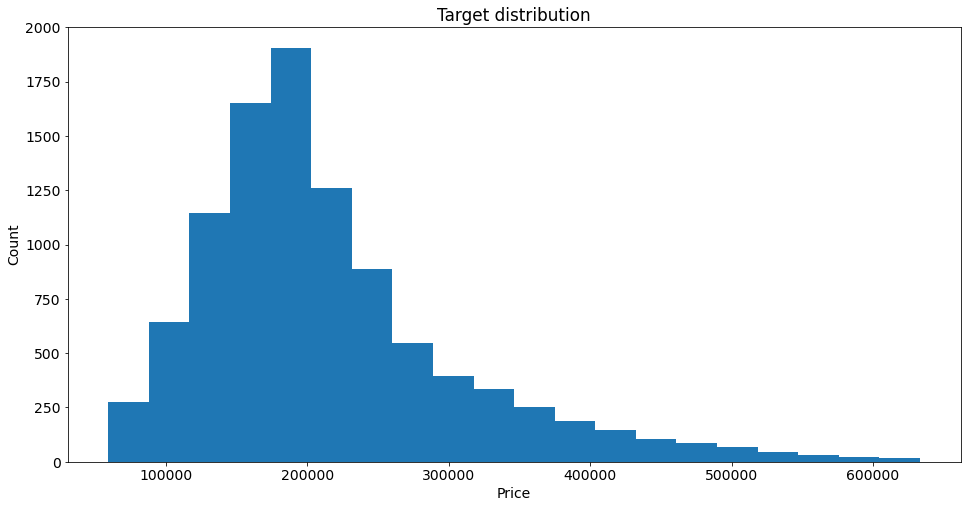

In [13]:
plt.figure(figsize = (16, 8))

plt.hist(train_df['Price'], bins=20)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')

plt.show()


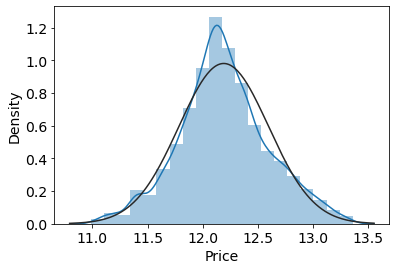

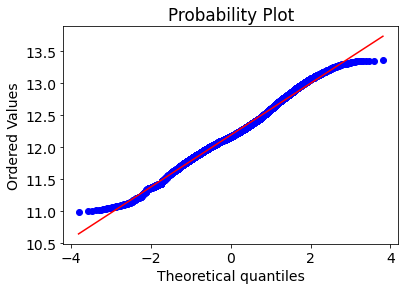

In [14]:
# просто для сравнения - логарифмическое преобразование убирает ассиметрию
sns.distplot(np.log(train_df['Price']), bins=20, fit=stats.norm)
fig = plt.figure()
res = stats.probplot(np.log(train_df['Price']), plot=plt)

**Количественные переменные**

In [15]:
# и сразу пропуски и разный масштаб данных
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [16]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
# повторов нет, номера уникальны, индекс - полезной информации не несёт
train_df['Id'].unique().size

10000

In [18]:
# 205 уникальных значений
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [19]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [20]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [21]:
# уже немного больше баланса
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Категории в Ecology_2 и Ecology_3 сильно не сбалансированы, вряд ли окажутся значимыми признаками

### 2. Обработка выбросов и пропусков

        - здесь уже только отобранные варианты заполнения/обрезки/новых признаков

<AxesSubplot:xlabel='Rooms'>

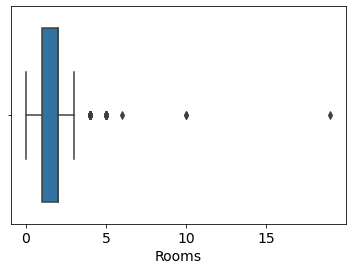

In [22]:
sns.boxplot(train_df['Rooms'], whis=1.5)

In [23]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Явные пики частот на 1, 2 и 3 (при этом далее интересные трёхглавые распределения для Square и LifeSquare), значения 0 и начиная примерно с 10 - неправдоподобны

In [24]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [25]:
# те, в приницпе, можно и сильнее обрезать
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

- **Square**

In [26]:
# min и max явно нуждаются в обрезке
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

<AxesSubplot:xlabel='Square'>

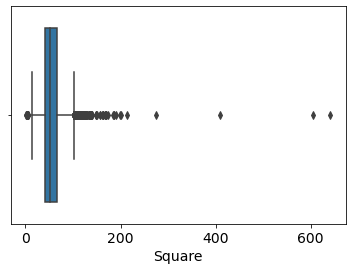

In [27]:
sns.boxplot(train_df['Square'], whis=1.5)

In [28]:
train_df['Square'].quantile(.975), train_df['Square'].quantile(.025)

(100.90624548226137, 32.10518291149681)

In [29]:
# произвольно выбранные цифры но с ориентировкой на квантили
train_df.loc[(train_df['Square'] < 30) | (train_df['Square'] > 150), 'Square'] = train_df['Square'].median()

<AxesSubplot:xlabel='Square', ylabel='Density'>

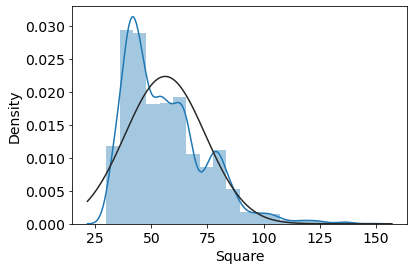

In [30]:
sns.distplot(train_df['Square'], bins=20, fit=stats.norm)

- **LifeSquare**

        - признак заметно коррелирует (что легко объяснимо) со Square (как и KitchenSquare), вместе со Square заметно ухудшает показатели r2 для модели

In [31]:
# пропусков чуть больше 1/5
train_df['LifeSquare'].isna().sum()

2113

In [32]:
# max и min также неправдоподобны
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [33]:
train_df['LifeSquare'].quantile(.025), train_df['LifeSquare'].quantile(.975)

(5.914129735023812, 80.74810407514713)

In [34]:
# жилая площадь превышает общую
train_df.loc[train_df['LifeSquare'] >= train_df['Square'], 'LifeSquare'].size

476

здесь просто вариант обработки, при котором признак показал наибольшую значимость в RandomForestRegressor - по сравнению со всеми признаками (а было их около 50), до предварительного отбора, те в окончательную модель не пойдёт

In [35]:
ls_per = (train_df['LifeSquare'] / train_df['Square']).sum() / train_df['LifeSquare'].count()
ls_per

0.6629151854710947

In [36]:
condition = train_df['LifeSquare'].isna() | (train_df['LifeSquare']  >= train_df['Square'])

In [37]:
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] * ls_per

проверяем

In [38]:
train_df['LifeSquare'].isna().sum()

0

In [39]:
train_df.loc[train_df['LifeSquare'] >= train_df['Square'], 'LifeSquare'].size

0

обрезаем выбросы

In [40]:
train_df.loc[(train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025)) | (train_df['LifeSquare'] > 100), 'LifeSquare'] = train_df['LifeSquare'].median()

<AxesSubplot:xlabel='LifeSquare', ylabel='Density'>

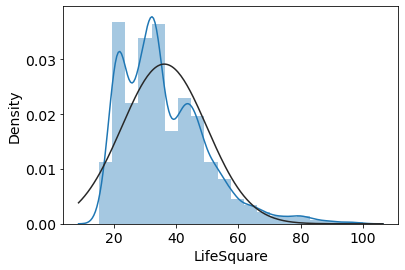

In [41]:
# вот оно то самое, трёхглавое
sns.distplot(train_df['LifeSquare'], bins=20, fit=stats.norm)

Было бы интересно разбить данные на 4 группы по комнатам (1-2-3-45) и посмотреть отдельно

- **KitchenSquare**

        - без пропусков, в основную модель не попадает из-за сильной связи со Square

In [42]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [43]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [44]:
# хотя столько значений сразу в середину распределения - так себе идея
train_df.loc[(train_df['KitchenSquare'] > 20) | (train_df['KitchenSquare'] < 3), 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [45]:
# KitchenSquare больше чем Square - LifeSquare
train_df.loc[train_df['KitchenSquare'] > train_df['Square'] - train_df['LifeSquare'], 'KitchenSquare'].size

741

Поскольку не ясно, каким данным стоит доверять (Square всё же чть предпочтительней), представляется, что не стоит слишком сильно подгонять показатели Square, LifeSquare и KitchenSquare друг к другу

In [46]:
# поэтому просто
train_df.loc[train_df['KitchenSquare'] > train_df['Square']] = train_df['KitchenSquare'].median()

- **Floor**, **HouseFloor**

        - пропущенных нет, HouseFloor задаёт границы для возможных Floor

In [47]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [48]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [49]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

Замена недостоверной этажности ('Floor' > 'HouseFloor') на случайный этаж в рамках высоты дома - из методички. Интересно, что замена на средний этаж конкретного дома дала худший результат

In [50]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = \
        train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor']\
        .apply(lambda x: random.randint(1, x))

In [51]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

- **HouseYear**

In [52]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [53]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

- **Ecology_1**

числа с большой точностью позволяют предположить, что они автоматическит откуда-то получены, те - малая вероятность недостоверности. Возможно, хороший признак

In [54]:
train_df['Ecology_1'].sort_values().unique()

array([0.00000000e+00, 1.80000000e-09, 6.99893000e-05, 7.81528000e-05,
       1.69676000e-04, 6.99119000e-04, 9.91363000e-04, 9.95363000e-04,
       2.21166500e-03, 4.94935800e-03, 5.76745100e-03, 6.07615200e-03,
       7.12231700e-03, 7.65851500e-03, 7.72028200e-03, 1.13198100e-02,
       1.16541270e-02, 1.23388860e-02, 1.25216340e-02, 1.40579200e-02,
       1.40729610e-02, 1.43339470e-02, 1.44231140e-02, 1.45807160e-02,
       1.50168920e-02, 1.76470530e-02, 1.95087960e-02, 2.07413260e-02,
       2.56091570e-02, 3.34937080e-02, 3.43314970e-02, 3.46560820e-02,
       3.51452670e-02, 3.61222920e-02, 3.62700890e-02, 3.71778180e-02,
       3.73164520e-02, 3.86929870e-02, 4.02427640e-02, 4.11163540e-02,
       4.11246340e-02, 4.13654460e-02, 4.20315870e-02, 4.23072710e-02,
       4.96372570e-02, 4.98633870e-02, 5.02720140e-02, 5.07555690e-02,
       5.09000580e-02, 5.18154350e-02, 5.19420620e-02, 6.07530490e-02,
       6.96603440e-02, 6.97533610e-02, 7.21575810e-02, 7.54236800e-02,
      

- **Social_1**, **Social_2**

In [55]:
train_df['Social_1'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 42, 43, 46, 47, 49, 50, 52, 53, 66, 74],
      dtype=int64)

In [56]:
train_df['Social_2'].sort_values().unique()

array([  168,   186,   264,   290,   388,   469,   475,   507,   528,
         568,   629,   662,   760,   915,  1135,  1227,  1318,  1423,
        1437,  1497,  1564,  1660,  1768,  1892,  1952,  1986,  2270,
        2277,  2370,  2398,  2423,  2514,  2733,  2738,  2748,  2787,
        2810,  2940,  3079,  3097,  3151,  3293,  3369,  3374,  3379,
        3433,  3478,  3594,  3681,  3684,  3746,  3806,  3856,  3889,
        3893,  3975,  4017,  4048,  4231,  4346,  4378,  4386,  4439,
        4472,  4583,  4625,  4635,  4724,  4756,  4788,  4789,  4798,
        4860,  5011,  5027,  5048,  5067,  5148,  5212,  5261,  5285,
        5288,  5469,  5487,  5562,  5569,  5613,  5648,  5664,  5731,
        5735,  5776,  5889,  5992,  6119,  6137,  6141,  6149,  6207,
        6398,  6533,  6558,  6564,  6566,  6714,  6746,  6748,  6783,
        6856,  7010,  7065,  7077,  7227,  7287,  7425,  7538,  7614,
        7651,  7687,  7715,  7759,  7960,  7976,  8004,  8429,  8647,
        8667,  9292,

вероятно, что один, что другой признак отражают какие-то условно "хорошие" показатели

In [57]:
train_df['Social_2'].corr(train_df['Price']), train_df['Social_1'].corr(train_df['Price'])

(0.23922559918745298, 0.26328586827670325)

Но их распределения подозрительно схожи между собой. Далее - два признака будут объединены в один.

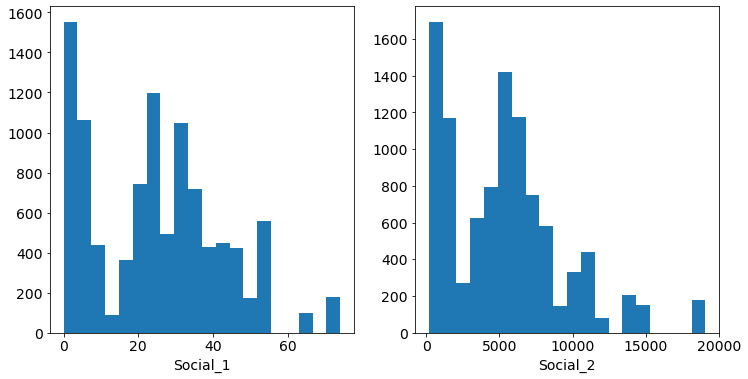

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12)
fig.set_figheight(6)

ax[0].hist(train_df['Social_1'], bins=20)
ax[0].set_xlabel('Social_1')

ax[1].hist(train_df['Social_2'], bins=20)
ax[1].set_xlabel('Social_2')

plt.show()

In [59]:
train_df['Social_1'].corr(train_df['Social_2'])

0.9559884611427014

- **Social_3**

In [60]:
train_df['Social_3'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,
        16,  19,  20,  23,  24,  27,  37,  39,  45,  48,  56,  59,  73,
        84,  87,  93, 141], dtype=int64)

- **Healthcare_1**

In [61]:
train_df['Healthcare_1'].sort_values().unique()

array([   0.,   30.,   32.,   35.,   46.,   75.,   80.,  100.,  125.,
        145.,  165.,  176.,  192.,  200.,  229.,  240.,  262.,  320.,
        325.,  350.,  370.,  520.,  540.,  562.,  620.,  628.,  645.,
        705.,  730.,  750.,  770.,  800.,  810.,  830.,  900.,  920.,
        990., 1015., 1020., 1036., 1046., 1084., 1130., 1145., 1183.,
       1308., 1322., 1340., 1406., 1430., 1450., 1547., 1548., 1575.,
       1786., 1815., 1894., 1937., 1940., 1970., 1994., 2078., 2300.,
       2301., 2500., 2620., 2643., 2672., 2715., 2729., 2857., 2890.,
       3300., 3855., 4087., 4129., 4508., 4702., 4849.,   nan])

In [62]:
# почти половина пропусков
train_df['Healthcare_1'].isnull().sum()

4798

Пара разных вариантов обработки (на всякий случай) результатов не дала.

- **Helthcare_2**

подозрительный признак: небольшое число уникальных - может быть как рангом так и (а вдруг) категорией

в итоге, ни он сам, ни признаки, сконструированные на его основе в итоговую модель не попали

In [63]:
train_df['Helthcare_2'].unique()

array([0, 1, 3, 2, 5, 4, 6], dtype=int64)

In [64]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

- **Shops_1**

In [65]:
train_df['Shops_1'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 19, 23],
      dtype=int64)

И снова очень много нулевых значений

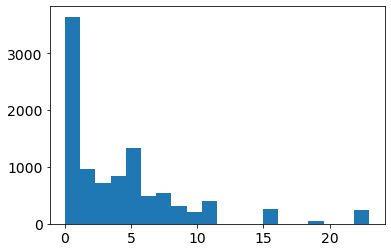

In [66]:
plt.hist(train_df['Shops_1'], bins=20);

#### Категориальные признаки

- **Ecology_2**, **Ecology_3**, **Shops_2**

In [67]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### Предобработка

In [68]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        # убрать, если не пригодится!
        self.square_quantile = None
        self.life_square_quantile = None
        self.life_square_per = None
        self.binary_to_numbers = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        self.medians = X.median()
        # убрать, если не пригодится!
        self.square_quantile = X['Square'].quantile(.025), X['Square'].quantile(.975)
        self.life_square_quantile = X['LifeSquare'].quantile(.025), X['LifeSquare'].quantile(.975)
        self.life_square_per = (X['LifeSquare'] / X['Square']).sum() / X['LifeSquare'].count()
        self.binary_to_numbers = {'A': 0, 'B': 1}
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        # Square
        X.loc[(X['Square'] < 30) | (X['Square'] > 150), 'Square'] = self.medians['Square']
        
        # LifeSquare
        condition = (X['LifeSquare'].isna() | (X['LifeSquare'] >= X['Square'])) & (~X['Square'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] * self.life_square_per
        
        X.loc[(X['LifeSquare'] < self.life_square_quantile[0]) | \
              (X['LifeSquare'] > 100), 'LifeSquare'] = self.medians['LifeSquare']
           
        # KitchenSquare
        X.loc[(X['KitchenSquare'] > 20) | (X['KitchenSquare'] < 3), 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
    
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = \
            X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        # Ecology_2, Ecology_3, Shops_2
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 3. Построение новых признаков

только те, что были отобраны для финальной модели

- **DistrictSize**

Целиком перетащено из методички, иные варианты обработки признака оказались менее значимыми для модели

In [69]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,11809,27,3.0,115.027311,76.253351,10.0,4,10.0,2014,0.075424,...,1,11,3097,0,NaN,0,0,1,305018.871089,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,30,6207,1,1183.0,1,0,1,177734.553407,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,33,5261,0,240.0,3,1,1,282078.720850,652
3,2352,1,1.0,40.409907,26.788341,6.0,10,22.0,1977,0.007122,...,1,1,264,0,NaN,0,1,1,168106.007630,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,33,8667,2,NaN,0,6,1,343995.102962,89


In [70]:
# интересно сравнить количество уникальных значений
train_df['DistrictId'].unique().size, train_df['DistrictSize'].unique().size

(205, 90)

- dummy для Floor: **Floor_first, Floor_between, Floor_last**

небольшую значимость показали сперва Floor_last, потом Floor_first

In [71]:
train_df['Floor_dummy'] = 0
# первый этаж
train_df.loc[train_df['Floor'] == 1, 'Floor_dummy'] = 1
# последний этаж
train_df.loc[(train_df['Floor'] != 1) & (train_df['Floor'] == train_df['HouseFloor']), 'Floor_dummy'] = 2

In [72]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Floor_dummy'])\
                      .rename(columns={0: 'Floor_betwin', 1: 'Floor_first', 2: 'Floor_last'})], axis=1)

In [73]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,Floor_dummy,Floor_betwin,Floor_first,Floor_last
0,11809,27,3.0,115.027311,76.253351,10.0,4,10.0,2014,0.075424,...,NaN,0,0,1,305018.871089,851,0,1,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,78,0,1,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,652,0,1,0,0
3,2352,1,1.0,40.409907,26.788341,6.0,10,22.0,1977,0.007122,...,NaN,0,1,1,168106.007630,652,0,1,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,NaN,0,6,1,343995.102962,89,2,0,0,1


- **HouseYear_bin**

признак первоначально создавался как основа для других, но сам показал неплохую значимость (в отличие от тех самых других)


бины основаны на этапах современного градостроительного развития города Москвы:

In [74]:
train_df['HouseYear_bins'] = pd.cut(train_df['HouseYear'], bins=[1900, 1930, 1940, 1945, 1955, 1970, 1980, 2000, 2010, 2020], labels=False)
train_df.loc[train_df['HouseYear_bins'].isna(), 'HouseYear_bins'] = -1

**Social_1_by_2**

вместо сильно коррелирующих Social_1 и Social_2

именно такая комбинация оказалась наиболее значимой

In [75]:
train_df['Social_1_by_2'] = 0
train_df.loc[~(train_df['Social_2'] == 0) , 'Social_1_by_2'] = train_df.loc[~(train_df['Social_2'] == 0), 'Social_1'] / train_df.loc[~(train_df['Social_2'] == 0), 'Social_2']

- **MedPriceByYear**

средняя цена за год - по сгруппированным годам 

не даёт сильного переобучения

In [76]:
med_price_by_year = train_df.groupby(['HouseYear_bins'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
train_df = train_df.merge(med_price_by_year, on='HouseYear_bins', how='left')

#### Генерация новых признаков

In [77]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_year = None
        self.district_size = None
        self.med_price_by_year = None
    
    def fit(self, X, y=None):
        
        X = X.copy()
 
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        # HouseYear
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df = self.year_to_cat(df)
            self.med_price_by_year = df.groupby(['HouseYear_bins'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
            
            self.med_price_by_year_median = self.med_price_by_year['MedPriceByYear'].median()
        
        
    def transform(self, X):
        
        # DistrictId, Districtsize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        # HouseYear_bins
        X = self.year_to_cat(X)   
        
        # Target encoding
        if self.med_price_by_year is not None:
            X = X.merge(self.med_price_by_year, on=['HouseYear_bins'], how='left')
            X['MedPriceByYear'].fillna(self.med_price_by_year_median, inplace=True)

        # Social_1_by_2    
        X['Social_1_by_2'] = 0
        X.loc[~(train_df['Social_2'] == 0) , 'Social_1_by_2'] = \
            X.loc[~(train_df['Social_2'] == 0), 'Social_1'] / train_df.loc[~(train_df['Social_2'] == 0), 'Social_2']
        
        # Floor_dummy
        X['Floor_dummy'] = 0
        # первый этаж
        X.loc[X['Floor'] == 1, 'Floor_dummy'] = 1
        # последний этаж
        X.loc[(X['Floor'] != 1) & (X['Floor'] == X['HouseFloor']), 'Floor_dummy'] = 2
        X = pd.concat([X, pd.get_dummies(X['Floor_dummy'])\
                      .rename(columns={0: 'Floor_betwin', 1: 'Floor_first', 2: 'Floor_last'})], axis=1)        
        
        return X
    
    def year_to_cat(self, X):
        bins = [1900, 1930, 1940, 1945, 1955, 1970, 1980, 2000, 2010, 2020]
        X['HouseYear_bins'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['HouseYear_bins'].fillna(-1, inplace=True)
        
        return X

### 4. Отбор признаков

- производился построением нескольких моделей на всей совокупности признаков, из которых потом была отобрана группа (около 5) достаточно значимых, но слабо между собой связанных (корреляционная матрица).
- далее в разных комбинациях добавлялись разные признаки со сравнением показателей r2
- в итоге:

In [78]:
selected_features = ['Square', 'Rooms', 'DistrictSize', 'Social_3', 'Social_1_by_2', 'HouseFloor', \
                     'Floor', 'HouseYear', 'MedPriceByYear', 'Ecology_1', 'Floor_last', \
                     'Floor_first', 'HouseYear_bins']

target_name = 'Price'

### 5. Разбиение на train и test

In [79]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [81]:
# предобработка
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

In [82]:
# генерация признаков
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 27), (3300, 27), (5000, 27))

In [83]:
# отбор признаков
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]
test_df = test_df[selected_features]

X_train.shape, X_valid.shape, test_df.shape

((6700, 13), (3300, 13), (5000, 13))

In [84]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 6. Построение модели

В качестве окончательной модели был выбран RandomForestRegressor с подбором параметров на GridSearchCV

Интересно, что неплохо себя показал KNN (r2 = 0.7 для валидационной выборки без подгонки и отбора)

In [85]:
rf_model = RandomForestRegressor(max_depth=17,
                                 max_features=5,
                                 min_samples_split=4,
                                 n_estimators=610,
                                 random_state=21,
                                 criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=17, max_features=5, min_samples_split=4,
                      n_estimators=610, random_state=21)

Train R2:	0.935
Test R2:	0.745


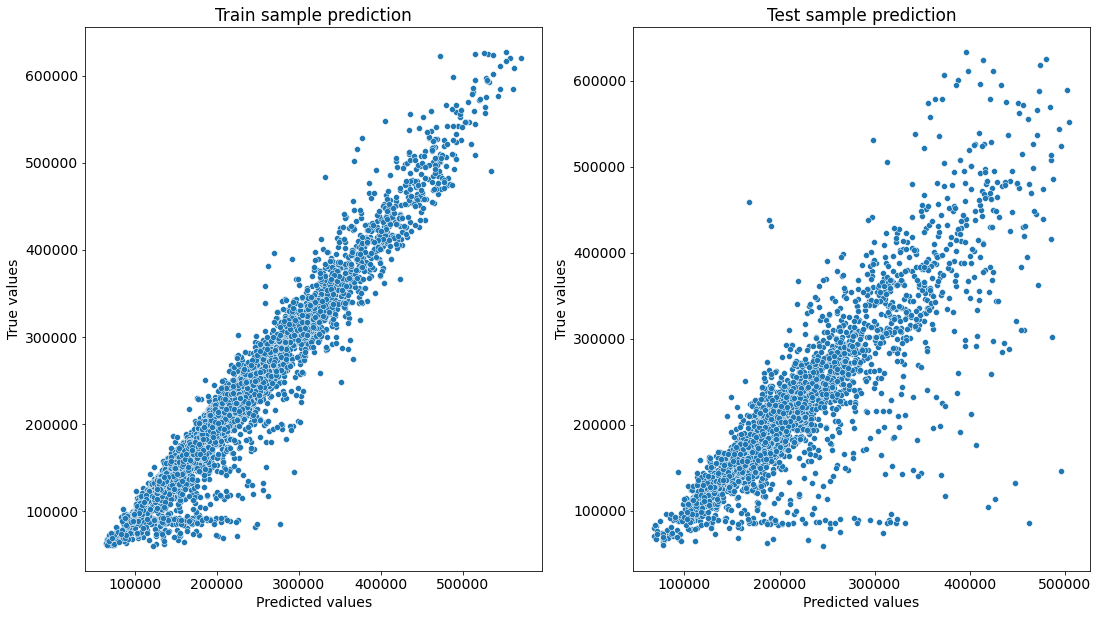

In [86]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [87]:
# кросс-валидация
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score, cv_score.mean()

(array([0.72780685, 0.66299467, 0.7161498 ]), 0.7023171085458637)

**Важность признаков**

In [88]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Square,0.334224
2,DistrictSize,0.170304
1,Rooms,0.137131
3,Social_3,0.088977
4,Social_1_by_2,0.056713
9,Ecology_1,0.053290
7,HouseYear,0.044230
5,HouseFloor,0.036907
8,MedPriceByYear,0.034734
6,Floor,0.025970


### 7. Прогнозирование на тестовом датасете

In [89]:
predictions = rf_model.predict(test_df)
predictions

array([160731.85964876, 121508.76258115, 141093.47055374, ...,
       147874.3627761 , 187968.2614617 , 234154.18379354])

In [90]:
submit = pd.read_csv('./sample_submission.csv')

In [91]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,160731.859649
1,5925,121508.762581
2,960,141093.470554
3,3848,159135.336710
4,746,195012.070258


In [92]:
submit.to_csv('OPorfiryeva_submit.csv', index=False)